# Описание проекта

Заказчик (сеть фитнес-центров) разрабатывают стратегию по работе с клиентами. Основная проблема - отток клиентов. В данном случае под оттоком понимается случай, когда клиент за последний месяц ни разу не посетил спортзал. Имеются данные клиентских анкет за предыдущий до проверки факта оттока месяц, а также информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента. 

**Цель исследования**: провести анализ данных и подготовить рекомендации по повышению удержания клиентской базы.

Содержание:
1. [Загрузка данных и EDA](#1)
2. [Построение модели прогнозирования оттока клиентов](#2)
3. [Кластеризация клиентов](#3)
4. [Итоговые выводы](#4)

## Загрузка данных и EDA
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
try:
    data = pd.read_csv('gym_churn.csv')
except:
     data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.duplicated().sum()

0

Датасет состоит из 4000 наблюдений и 14 столбцов. Пропуски и дубликаты отсутствуют, столбы приведены к верным типам данных.

In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
data.query('Lifetime > 24')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
897,1,1,0,0,1,12,0,31,116.054082,10.0,31,2.378748,2.307312,0
915,1,1,1,1,0,12,1,30,256.685355,11.0,26,1.202611,1.384090,0
1810,0,1,1,0,1,12,1,29,193.176830,7.0,27,0.000000,0.000000,0
2355,0,1,0,0,1,1,0,30,40.559417,1.0,26,1.663034,1.750301,0
2873,1,1,0,0,1,1,0,29,183.715050,1.0,29,1.750208,1.608273,0


Ярких выбросов и аномалий не обнаружено, разброс в данных не велик. В столбце `Lifetime` есть необычно высокие значения (более 24 месяцев) - в базе есть особо преданные клиенты, которые посещают фитнес-центр более 2 лет.

In [7]:
# соотношение классов клиентов
data['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Выведем средние значения признаков по двум классам клиентов (действующие и ушедшие) и посмотрим на распределения признаков.

In [8]:
data.groupby('Churn').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


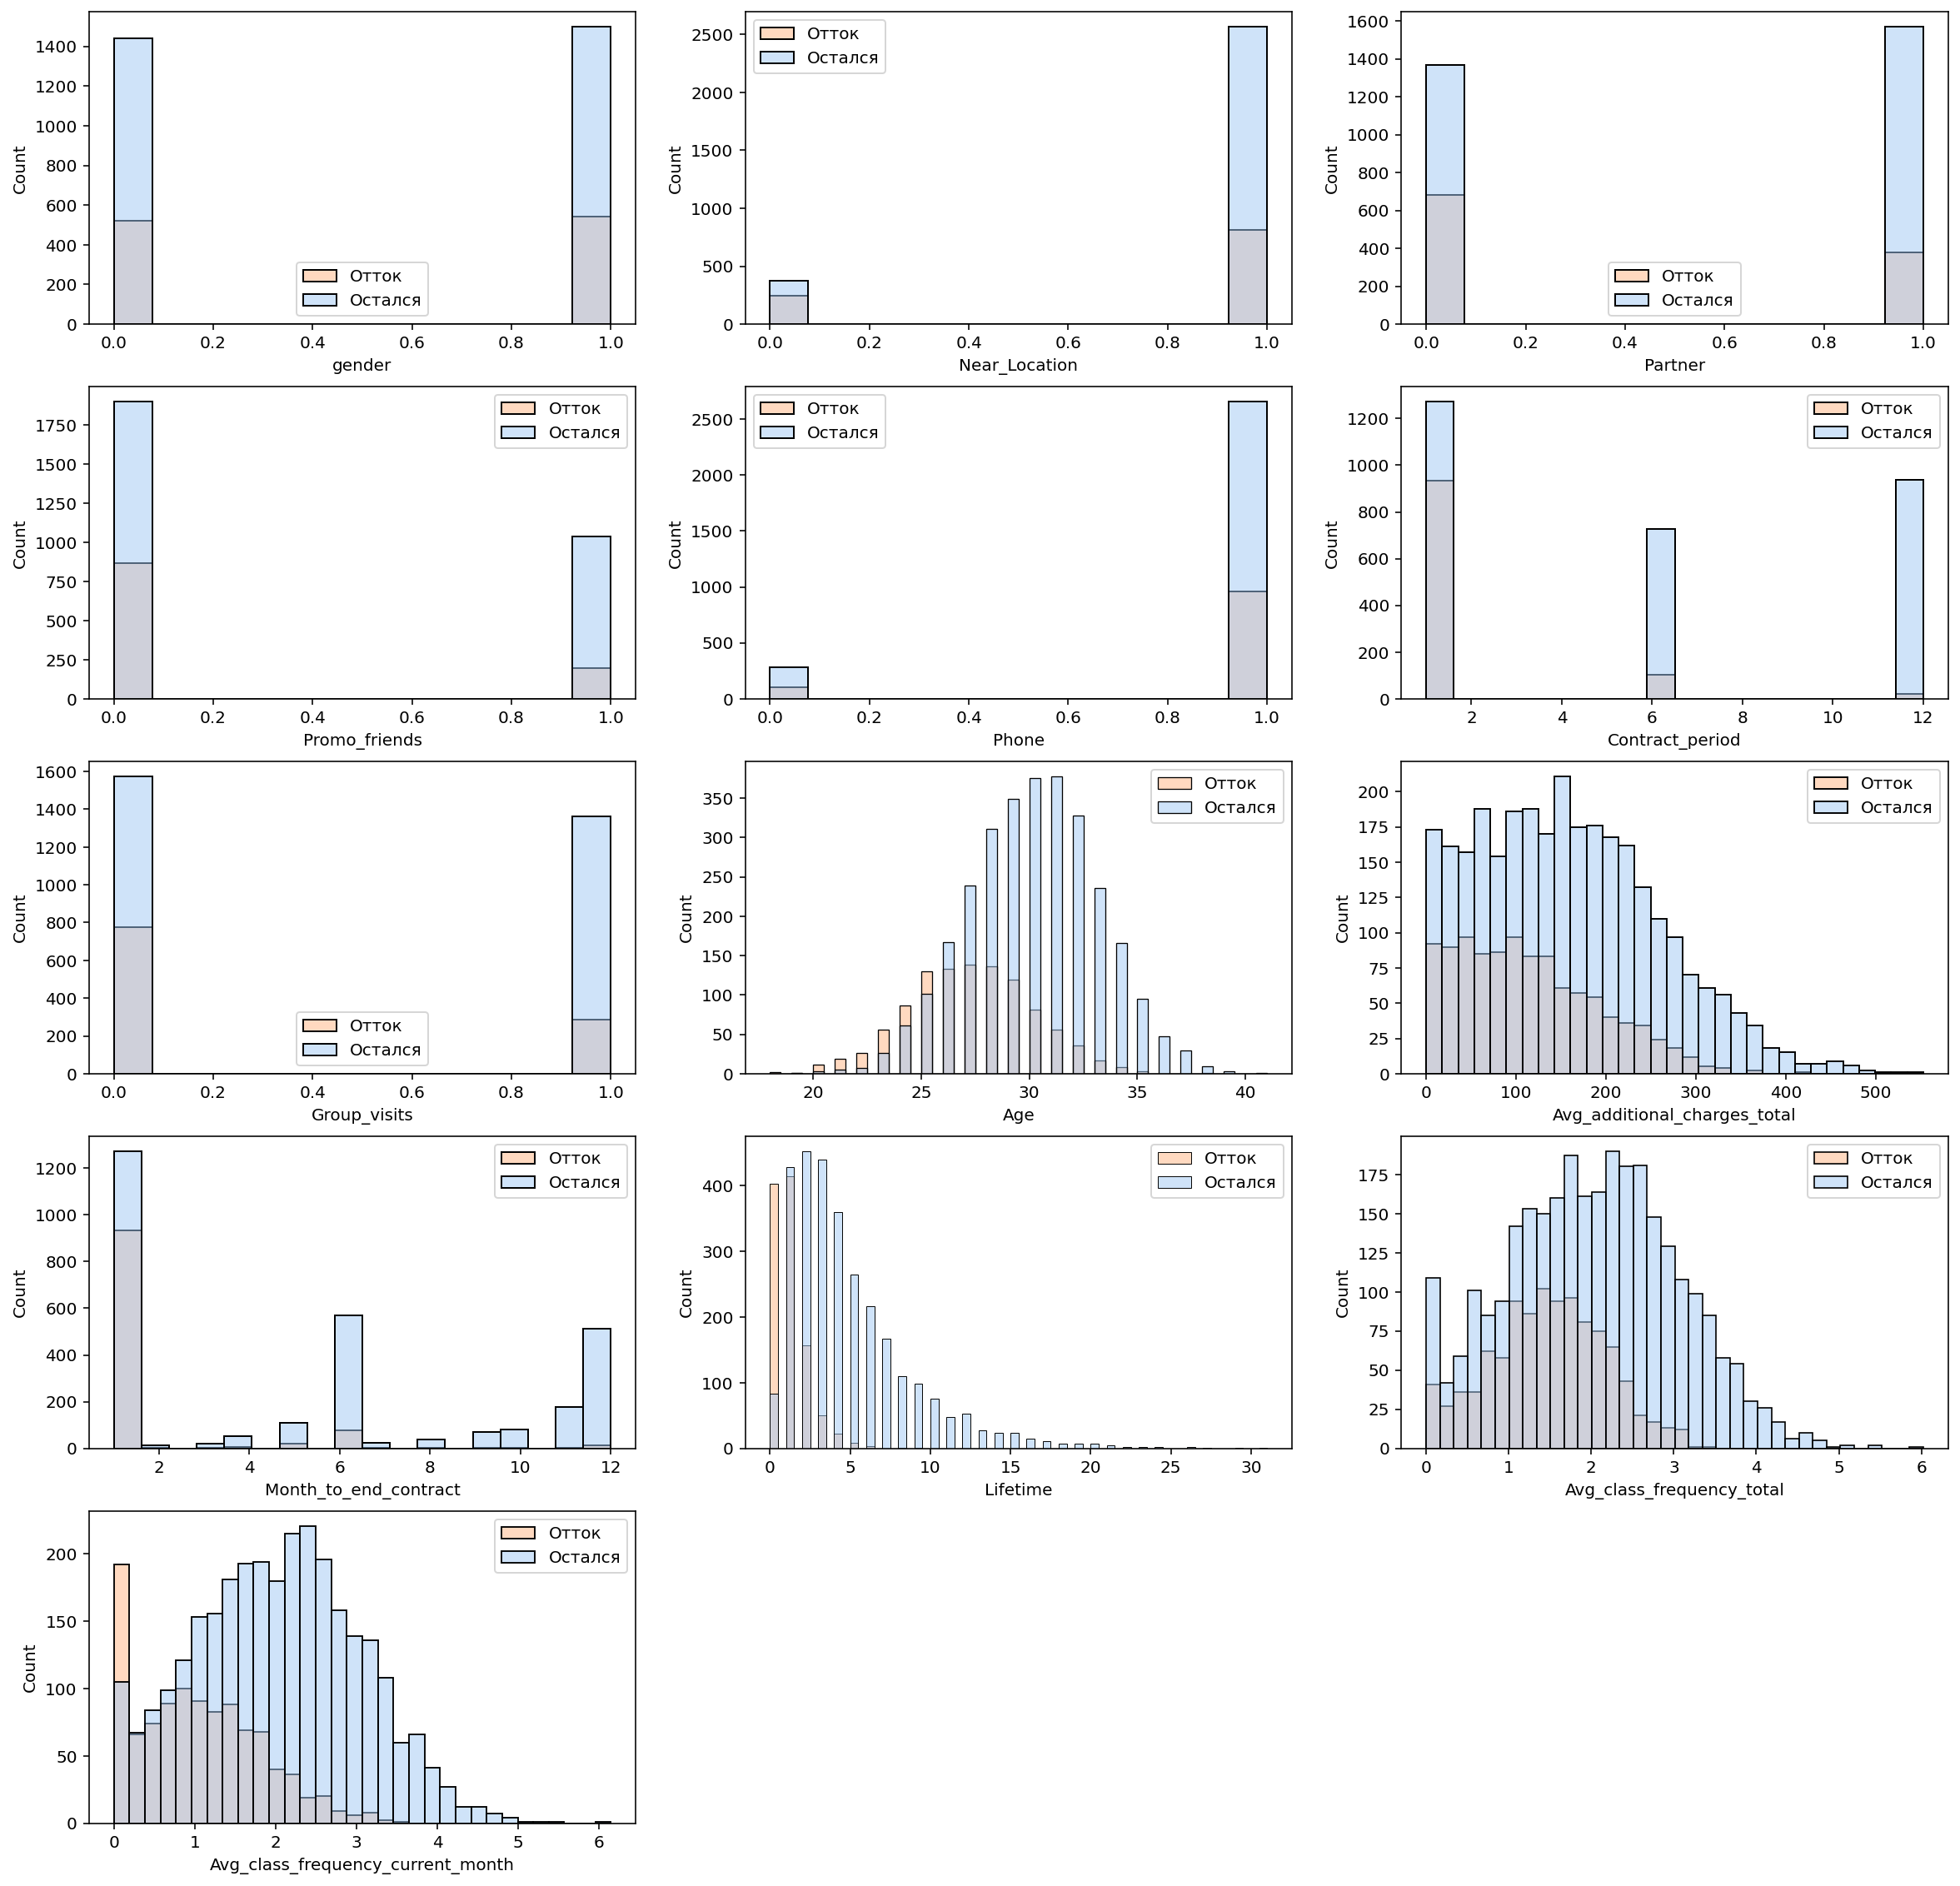

In [9]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(data.drop('Churn', axis=1).columns):
    sns.histplot(x=feature, data=data, hue='Churn', ax=plt.subplot(5, 3, i+1), palette='pastel')
    plt.legend(labels=['Отток', 'Остался'])
    
plt.show()

Такие признаки, как Near_Location, Partner, Promo_friends, Group_visits чаще встречаются у действующих клиентов. Кол-во мужчин и женщин примерно одинаково в обоих классах. Телефон оставляют почти все клиенты. Длительность абонементов у действующих клиентов в среднем 6 мес, в то время как ушедшие в отток чаще приобретают месячные абонементы. Средний возраст действующих клиентов чуть выше. Также они больше тратят на дополнительные услуги и имеют более длительные отношения с фитнес-клубом, т.е. являются более вовлеченными и заинтересованными.

Проверим признаки на наличие корреляции.

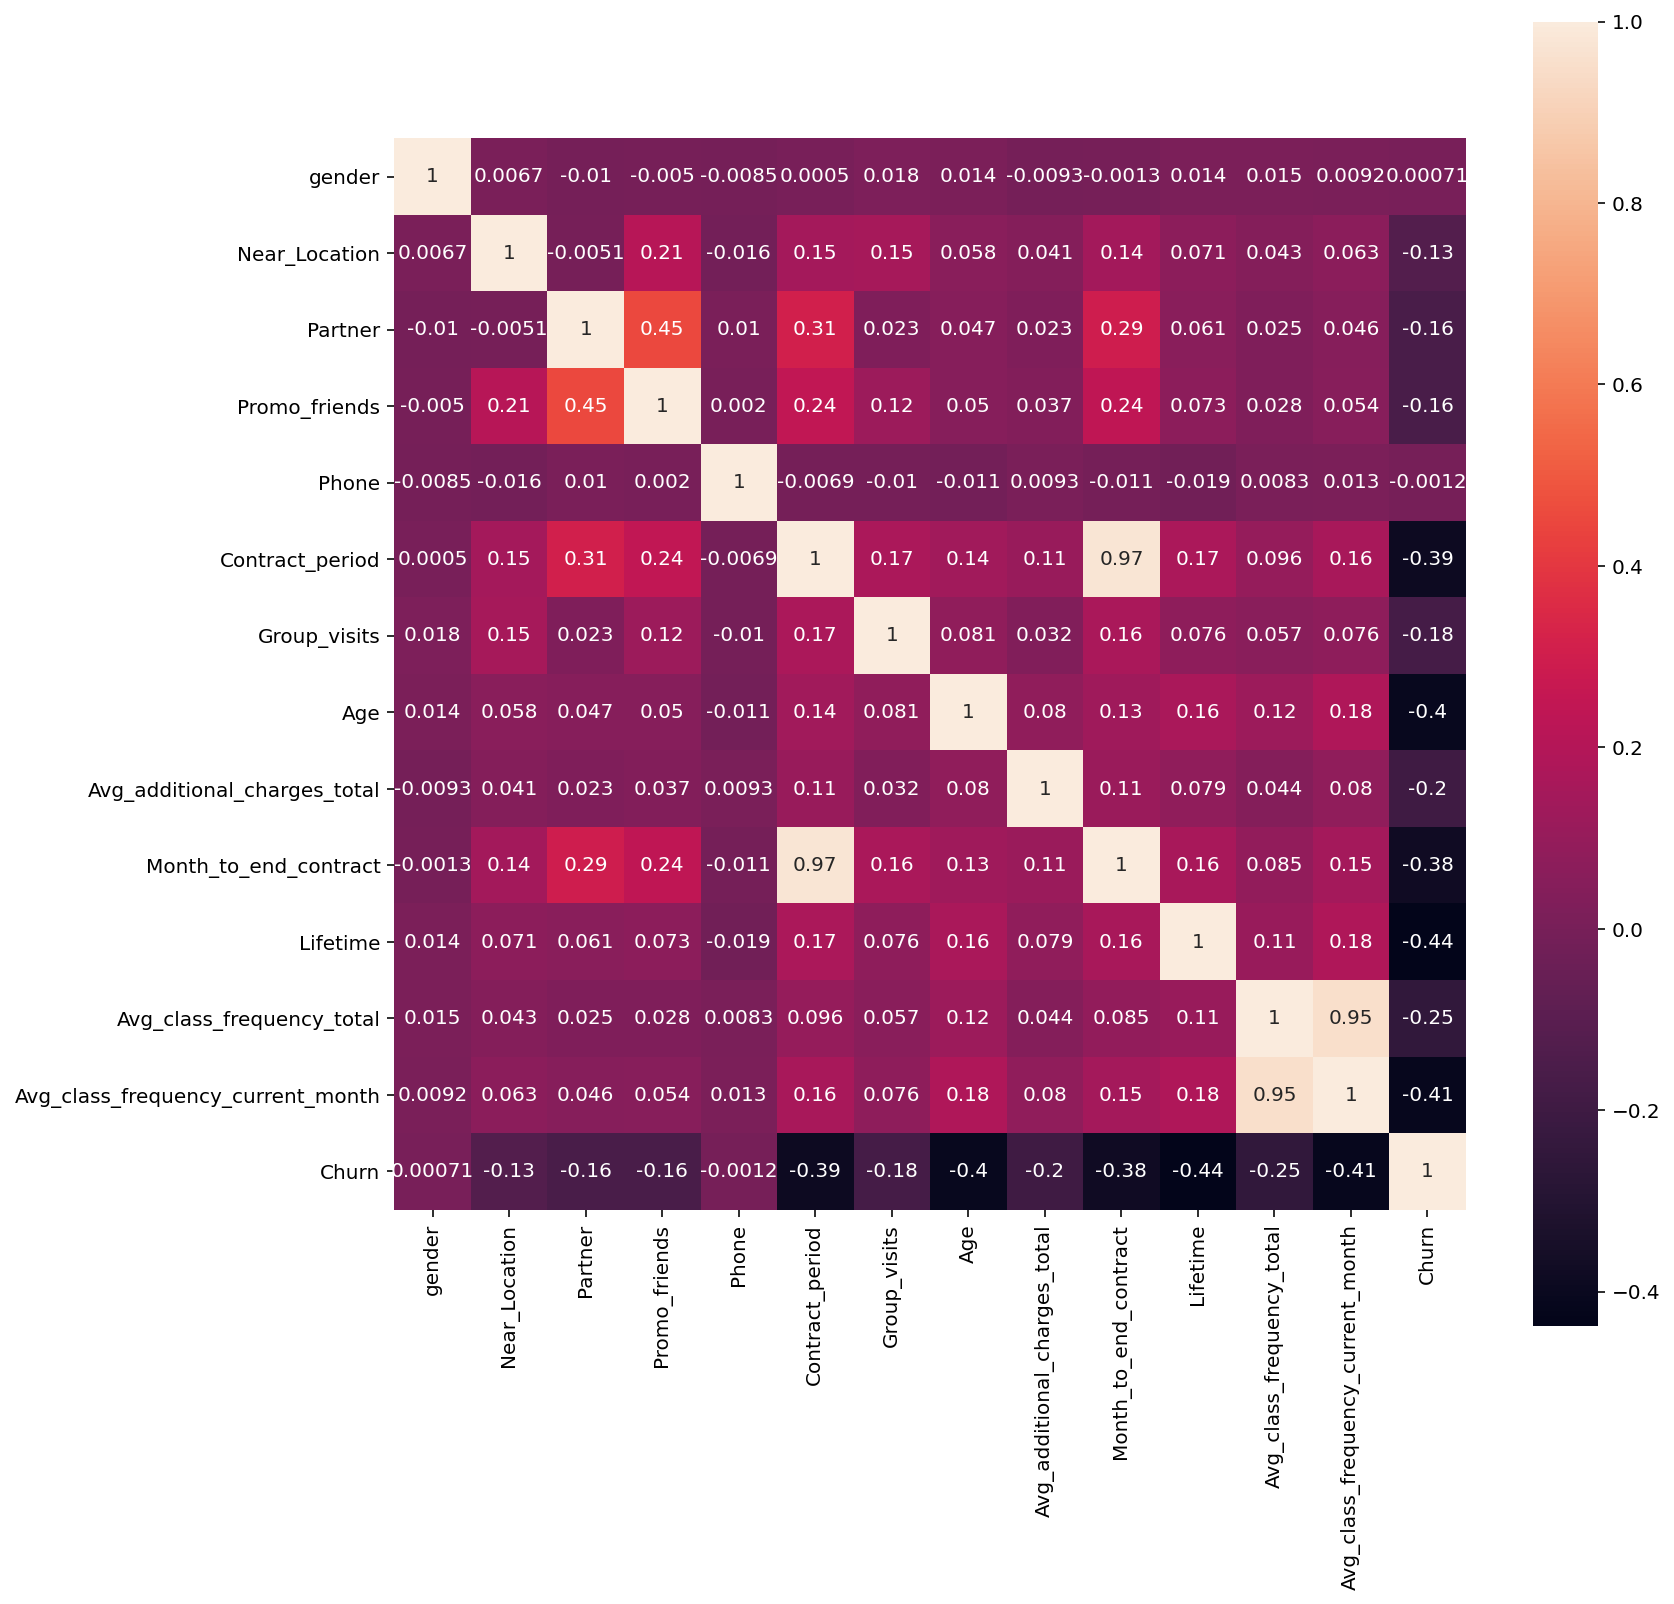

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), square=True, annot=True)
plt.show()

**Вывод:**
Присутствует мультиколлинеарность между `Contract_period` и `Month_to_end_contract`, а также между `Avg_class_frequency_total` и `Avg_class_frequency_current_month`. Также заметна умеренная обратная зависимость между оттоком и длительностью абонемента, возрастом, временем с момента первого обращения и средней частотой посещений в неделю. Выводы соотносятся с полученными ранее в ходе исследования распределения признаков.

Можно предположить, что чем больше значение описанных выше фичей, тем меньше вероятность, что клиент уйдет.

## Построение модели прогнозирования оттока клиентов
<a id='2'></a>

Целевая переменная `y` - отток клиентов `Churn`. Вектору признаков `X` соответствует 13 столбцов датафрейма data. Построим модель бинарной классификации клиентов.

In [11]:
X = data.drop('Churn', axis=1)
y = data['Churn']

# разбиваем выборку на обучающую и валидационную в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# зададим алгоритм логистической регресии
model = LogisticRegression(solver='liblinear', random_state=0)

# обучаем модель на обучающей выборке
model.fit(X_train, y_train)

# делаем прогноз на валидационной выборке
predictions = model.predict(X_test)
# получаем оценку вероятности принадлежности ко второму классу (отток)
probabilities = model.predict_proba(X_test)[:,1]

# выводим метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [12]:
X = data.drop('Churn', axis=1)
y = data['Churn']

# разбиваем выборку на обучающую и валидационную в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# зададим алгоритм случайного леса
model = RandomForestClassifier(random_state=0)

# обучаем модель на обучающей выборке
model.fit(X_train, y_train)

# делаем прогноз на валидационной выборке
predictions = model.predict(X_test)

# выводим метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


**Вывод:**
Делать выводы об успешности модели по метрике Accuracy в данном случае не корректно, т.к. не соблюден баланс классов (действующих клиентов почти в 3 раза больше, чем ушедших). Precision и Recall у алгоритма логистической регресии показывают хорошие результаты. У алгоритма случайного леса метрики чуть хуже.

## Кластеризация клиентов
<a id='3'></a>

Перед проведением кластеризации приведем все фичи к единому масштабу.

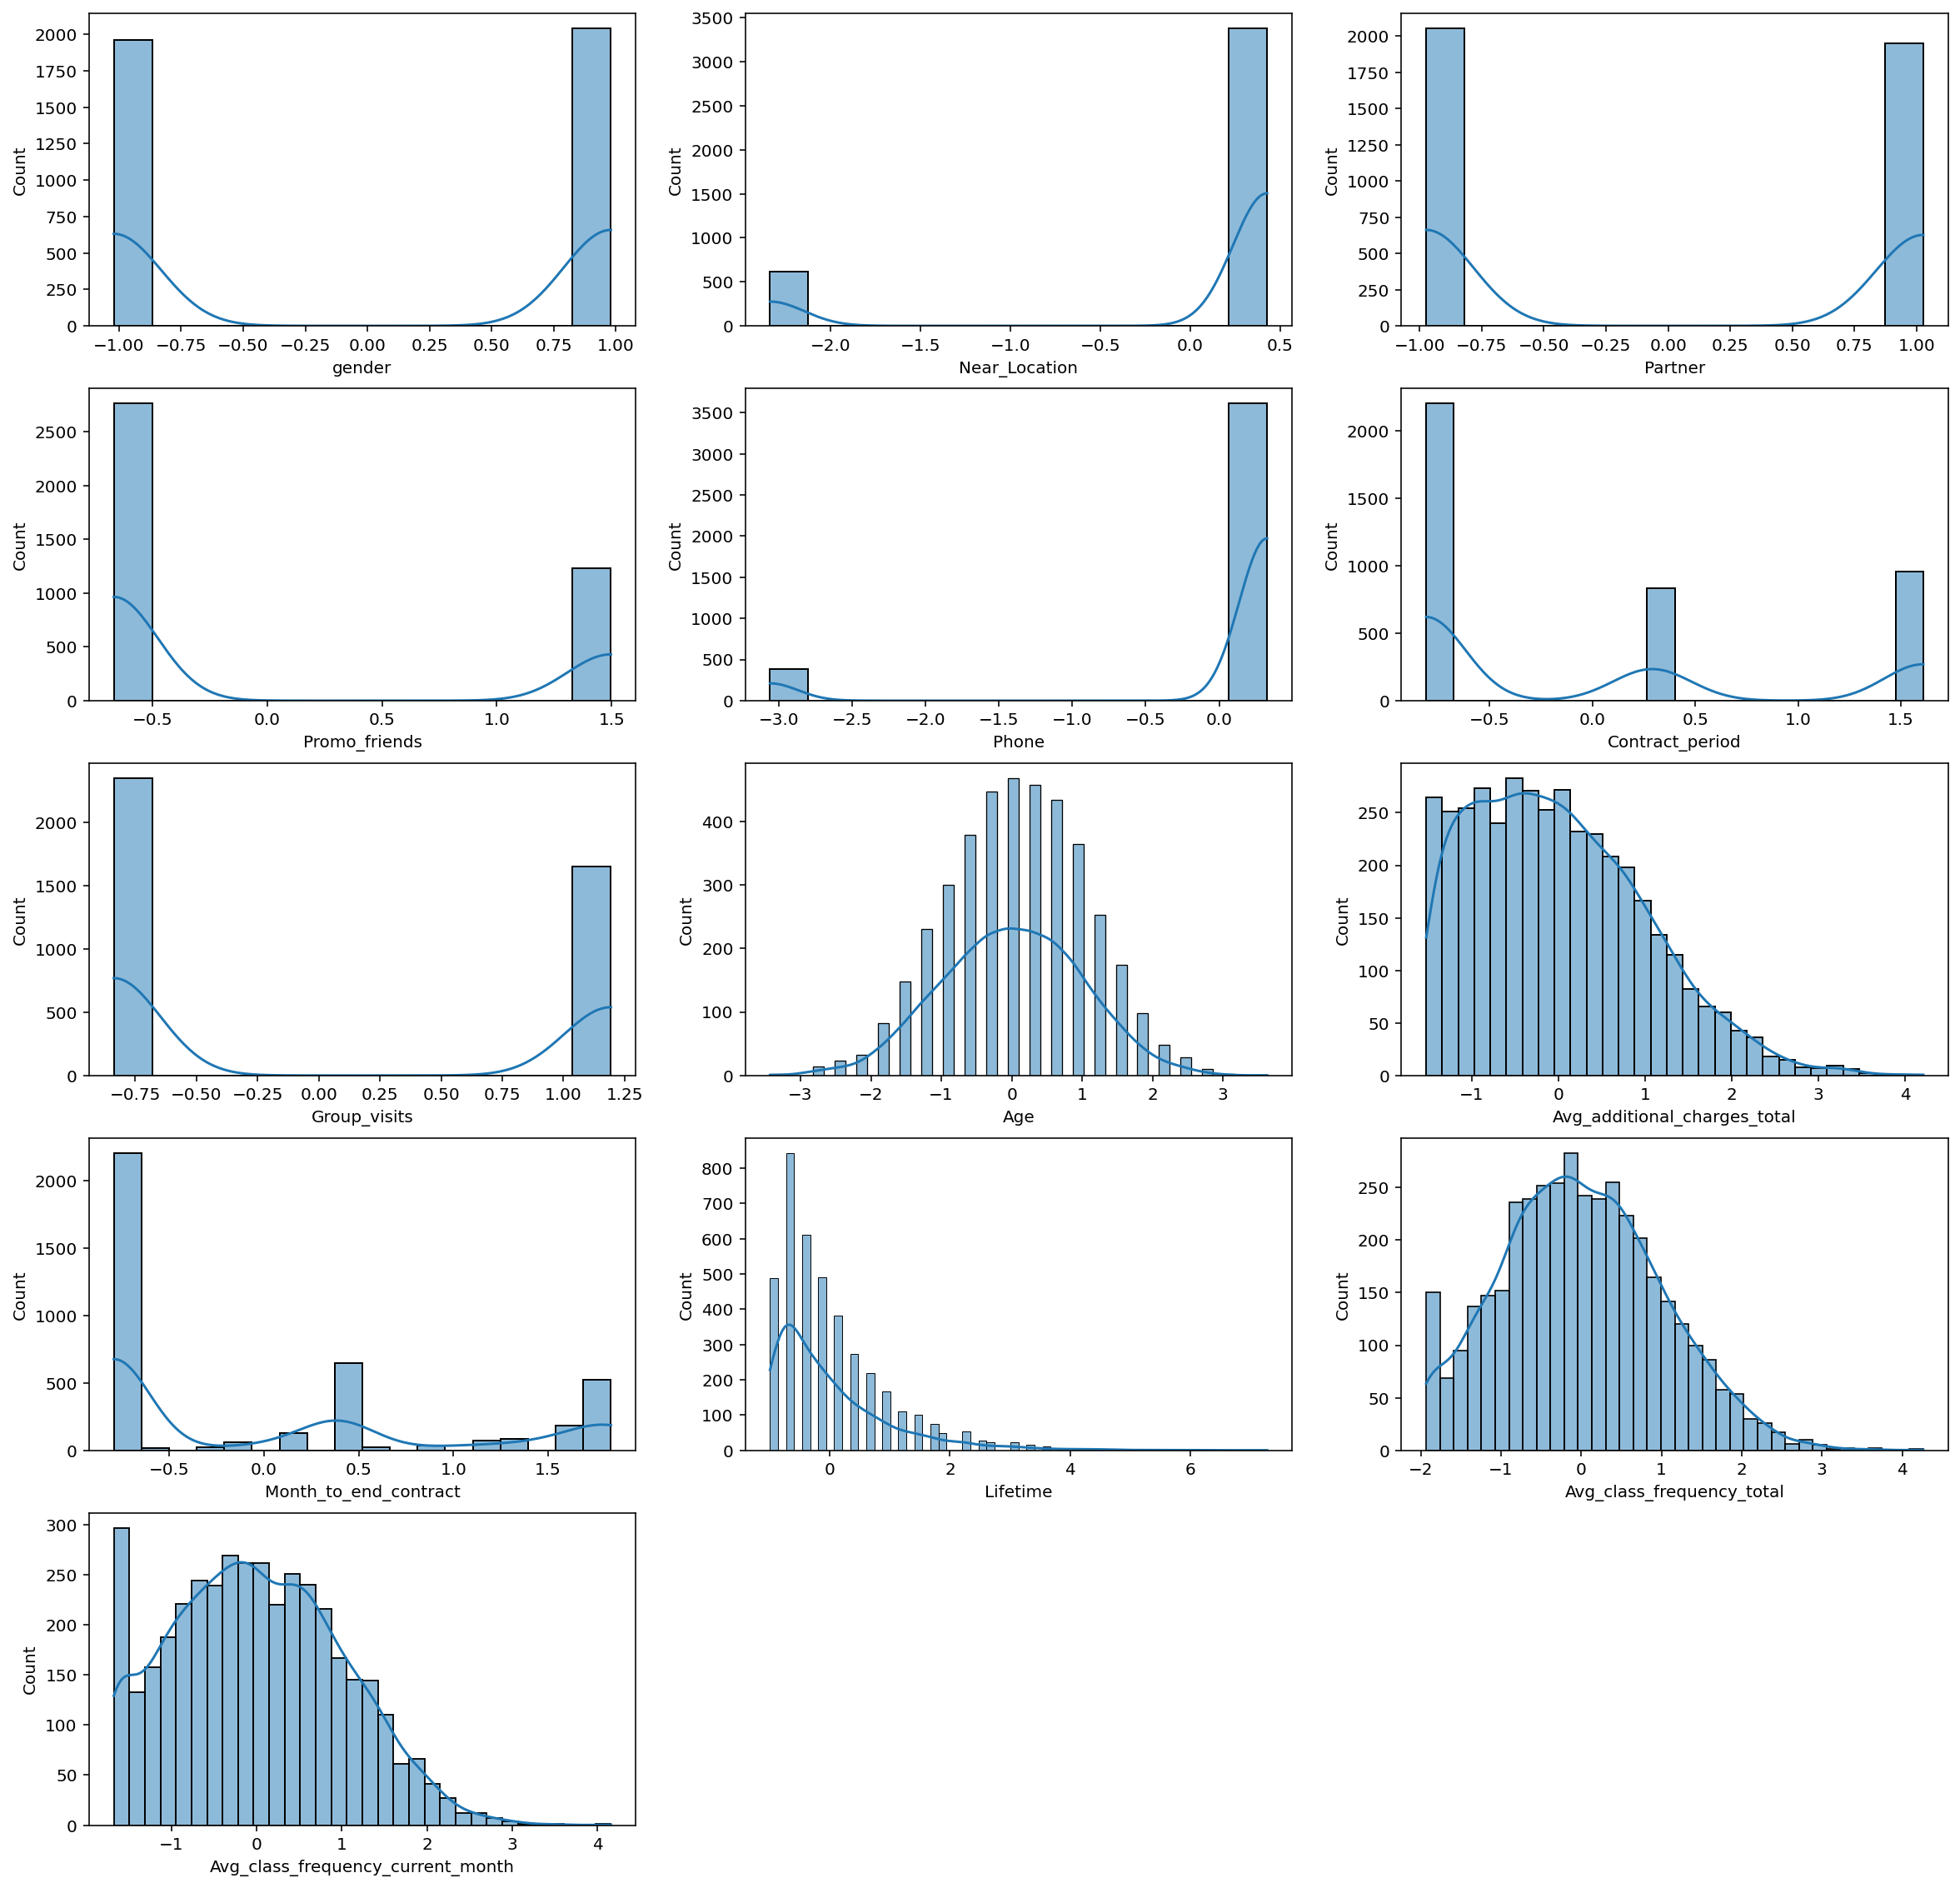

In [13]:
# проводим стандартизацию признаков
scaler = StandardScaler()

# обучаем стандартизатор
scaler.fit(data.drop('Churn', axis=1))

# преобразуем фичи
X_sc = scaler.transform(data.drop('Churn', axis=1))

# создаем новый датафрейм
data_sc = pd.DataFrame(
    data = X_sc,
    columns = data.drop('Churn', axis=1).columns
)

plt.figure(figsize=(20,20))

for i, feature in enumerate(data_sc.columns):
    sns.histplot(x=feature, data=data_sc, ax=plt.subplot(5, 3, i+1), kde=True)
    
plt.show()

Построим дендрограмму и посмотрим, какое количество кластеров можно выделить.

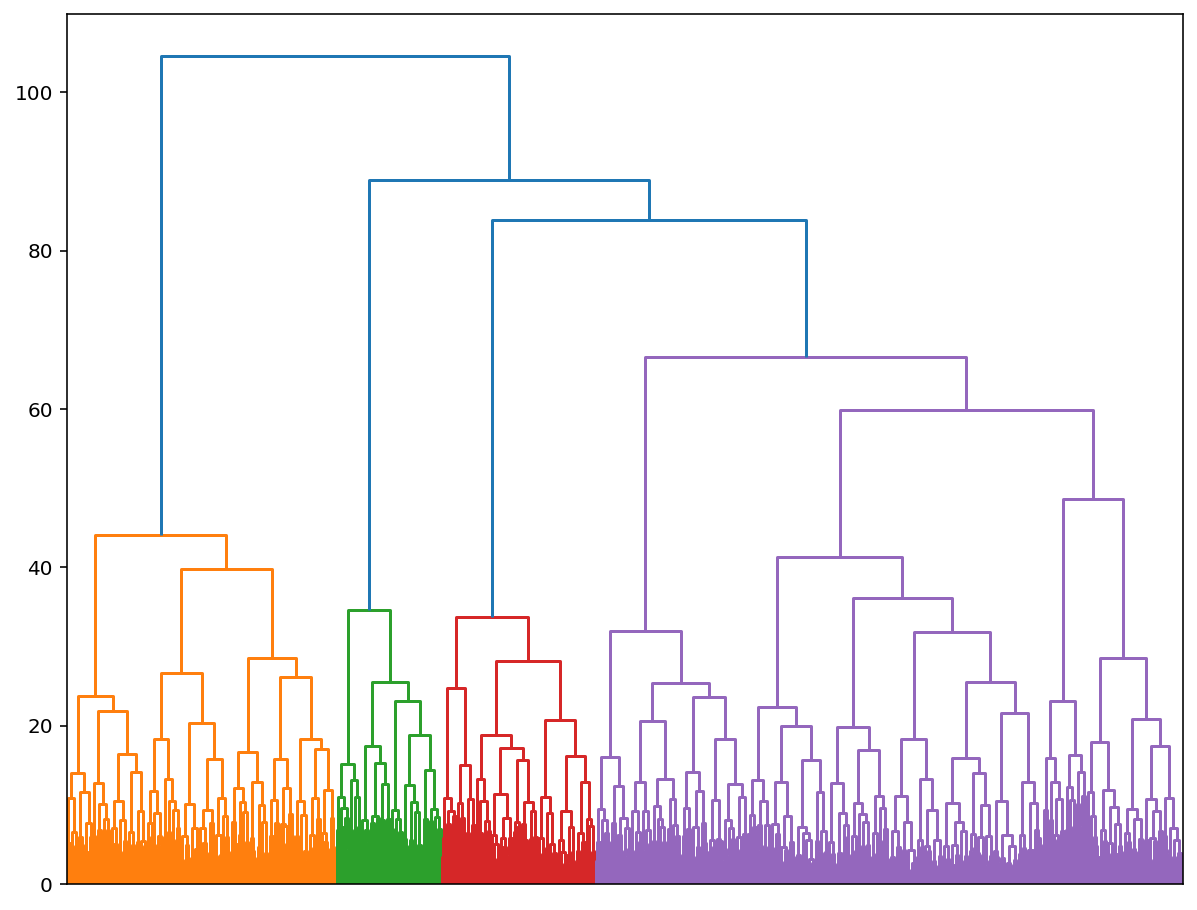

In [14]:
linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(10,8))
dendrogram(linked, orientation='top', no_labels=True)
plt.show()

Предложенное оптимальное число кластеров - 4. Согласно заданию, число кластеров необходимо принять n=5. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [15]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в датасет
data['cluster'] = labels

# выводим средние значения фичей по кластерам
data.groupby('cluster').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Среднее значение большинства признаков (за исключением пола, возраста, наличие номера телефона) достаточно сильно различается между кластерами. Посмотрим на распределения признаков в разрезе каждого кластера.

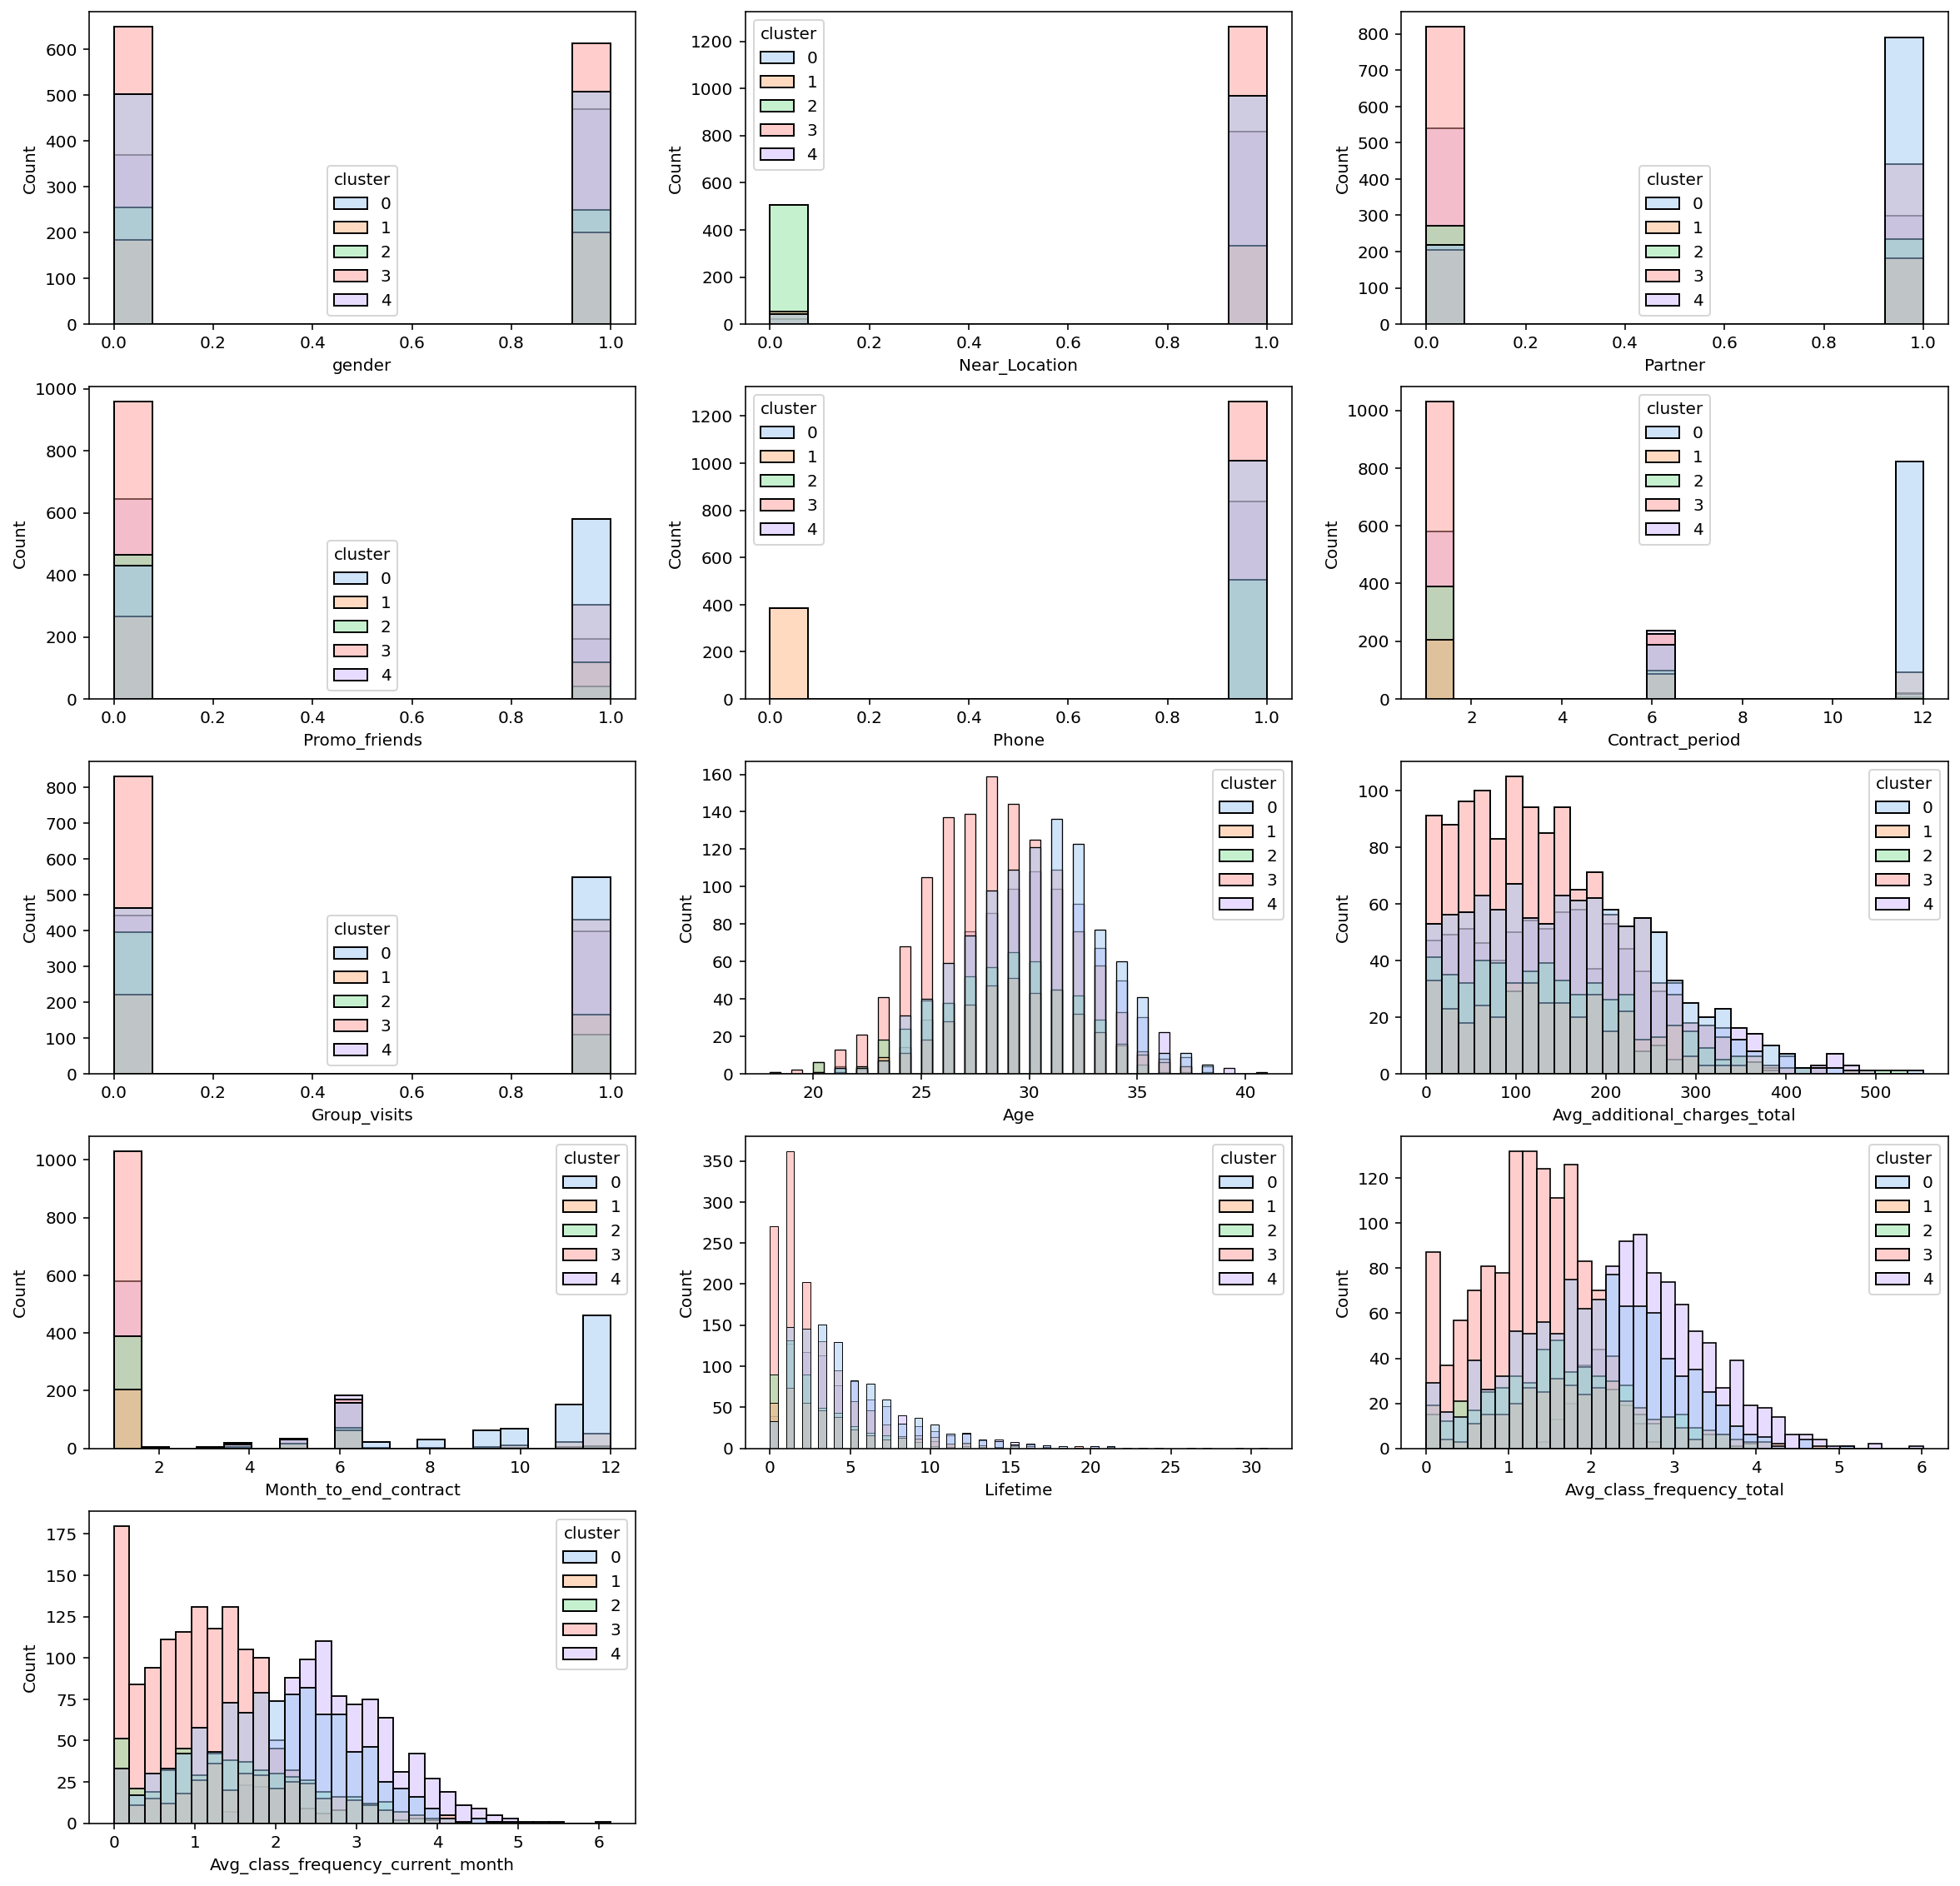

In [16]:
plt.figure(figsize=(20,20))

for i, feature in enumerate(data.drop(['Churn', 'cluster'], axis=1).columns):
    sns.histplot(x=feature, data=data, hue='cluster', ax=plt.subplot(5, 3, i+1), palette='pastel')
    
plt.show()

In [17]:
# доли ушедших в отток клиентов в разбивке по кластерам
data.groupby('cluster')['Churn'].agg('mean')

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64

Характер распределений похожий, однако есть ярко выраженные различия по некоторым фичам между кластерами "0", "4" и "3". Кластер "0" имеет наименьшую долю ушедших в отток клиентов, кластер "3" - наибольшую. В целом кластеры "0" и "4" практически идентичны, можно объединить их в один.

## Итоговые выводы
<a id='4'></a>

Портрет клиента кластера "0" (преданные клиенты):
- проживает или работает рядом с фитнес-центром;
- чаще всего является сотрудником компании-партнёра клуба;
- часто приходит по акции "приведи друга";
- чаще всего имеет абонемент длительностью 1 год;
- средний возраст около 30 лет;
- активно пользуется дополнительными услугами фитнес-центра;
- является клиентом в среднем более 4 мес.;
- занимается по 2-3 раза в неделю.

Портрет клиента кластера "3" (склонны к оттоку):
- проживает или работает рядом с фитнес-центром;
- чаще всего приходит "со стороны";
- обычно покупает краткосрочный абонемент;
- средний возраст около 28 лет;
- не так активно приобретает доп.услуги;
- ходит в зал реже (в среднем 1 раз в неделю).

Основные признаки, наиболее сильно влияющие на отток: 
- длительность абонемента; 
- возраст; 
- время с момента первого обращения;
- средняя частота посещений в неделю.

**Рекомендации по повышению удержания клиентской базы:**
- мотивировать клиентов к покупке долгосрочных абонементов через скидки/рассрочки оплаты;
- сфокусировать рекламную кампанию на приоритетное привлечение клиентов возраста 30+ (расширить сеть компаний-партнеров);
- внедрить неназойливые, мотвирующие напоминания о тренировках через мессенджеры, если клиент неделю не приходил в фитнес-центр.